# SC1015 MINI-PROJECT

OBJECTIVE: TO FIND THE BEST METHODOLOGY IN PREDICTING STOCK PRICES

SECTION 1: IMPORTING NECESSARY LIBRARIES

SECTION 2: DATA PREPROCESSING

SECTION 3: RMSE AND MAPE

SECTION 4: DIVIDING TRAIN AND TEST DATA

SECTION 5: #1 NAIVE

SECTION 6: #2 MA-30; MA-50; MA-200

SECTION 7: #3 Exponential Smoothing

SECTION 8: #4 LSTM

SECTION 9: CONCLUSION

# SECTION 1 - IMPORTING NECESSARY LIBRARIES

In [17]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#essential for LSTM model
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

# SECTION 2 - DATA PREPROCESSING

In [18]:
stock_cleaned_data=pd.read_csv('../data/stock_cleaned_data.csv', index_col = 0)

In [19]:
stock_cleaned_data.head()

,open,high,low,close,adjclose,volume
date,,,,,,
2023-04-18,415.58,415.72,412.7802,414.21,414.21,63559997
2023-04-17,412.37,413.96,411.0850,413.94,413.94,65496534
2023-04-14,412.81,415.09,410.0600,412.46,412.46,78161500
2023-04-13,409.18,413.84,407.9922,413.47,413.47,85814754
2023-04-12,411.87,412.17,407.4400,408.05,408.05,86420379


In [20]:
stock_cleaned_data = stock_cleaned_data[::-1]
stock_cleaned_data.head()

,open,high,low,close,adjclose,volume
date,,,,,,
1999-11-01,136.500000,137.000000,135.562500,135.562500,88.217185,4006500
1999-11-02,135.968704,137.250000,134.593704,134.593704,87.586742,6516900
1999-11-03,136.000000,136.375000,135.125000,135.500000,88.176513,7222300
1999-11-04,136.750000,137.359299,135.765594,136.531204,88.847568,7907500
1999-11-05,138.625000,139.109299,136.781204,137.875000,89.722043,7431500


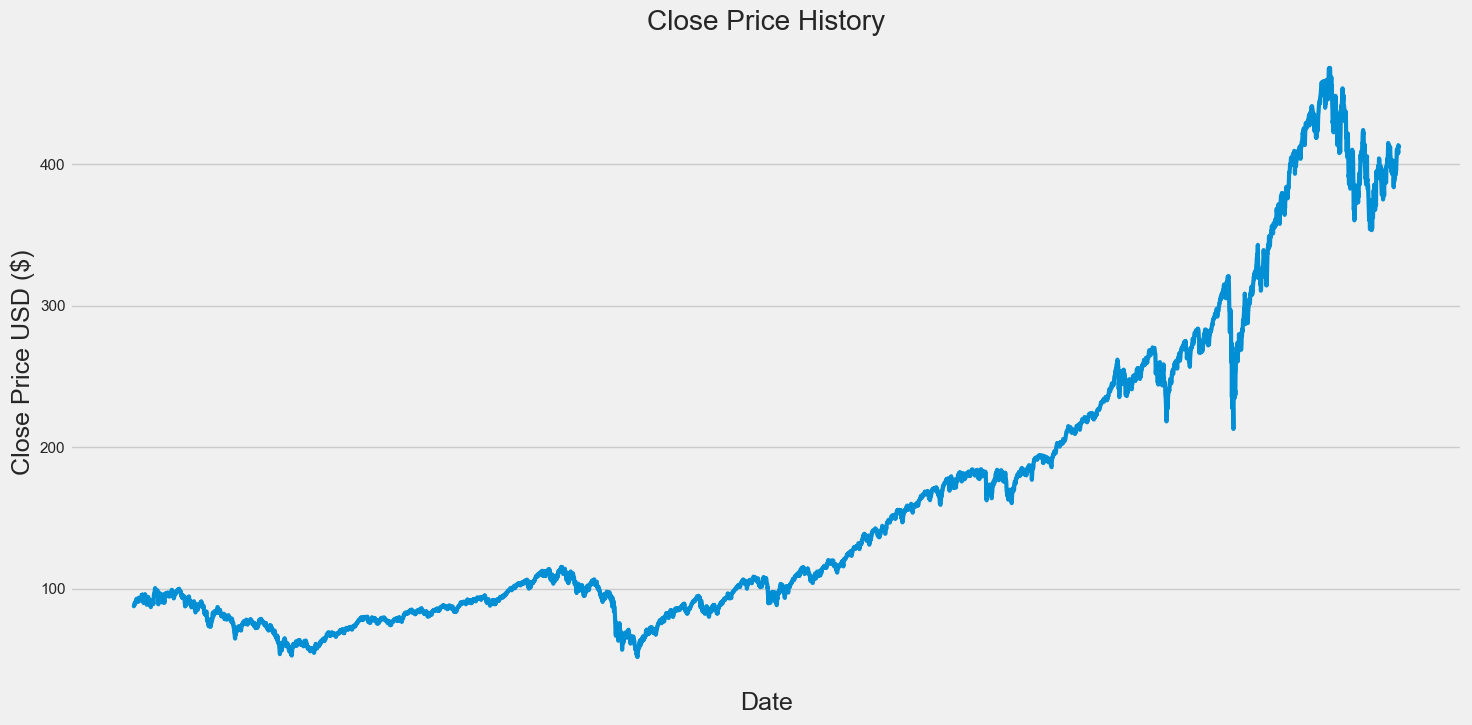

In [21]:
#plot the stock price graph
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(stock_cleaned_data['adjclose'], linewidth=3)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.xticks([])
plt.show()

# Section 3 - Exploratory Data Analysis

<Axes: xlabel='volume', ylabel='Count'>

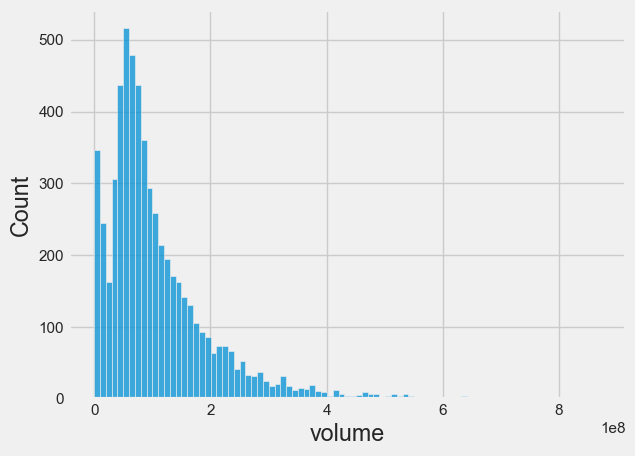

In [23]:
sns.histplot(x='volume', data=stock_cleaned_data)

Correlation Coefficient: -0.13274584140618198


Text(16.33333333333333, 0.5, 'Volume')

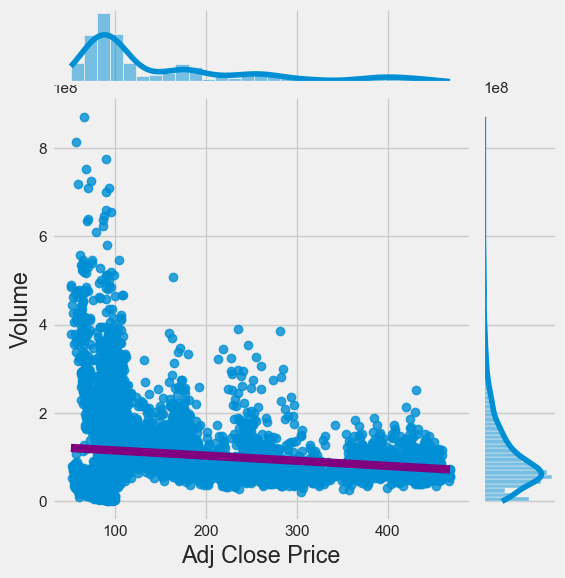

In [24]:
corr_coeff = stock_cleaned_data['volume'].corr(stock_cleaned_data['adjclose'])
print('Correlation Coefficient:', corr_coeff)

sns.jointplot(x='adjclose', y='volume', data=stock_cleaned_data, kind='reg', 
              line_kws={'color': 'purple'})

plt.xlabel('Adj Close Price')
plt.ylabel('Volume')

Correlation Coefficient: 0.20952449585622854


Text(16.33333333333333, 0.5, 'Volume')

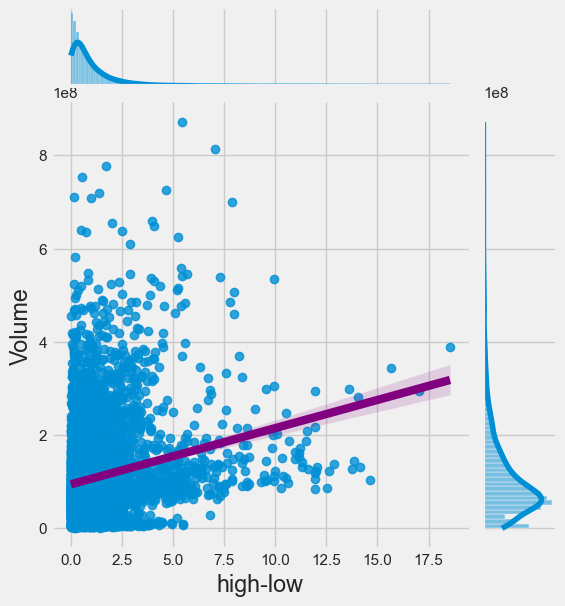

In [25]:
corr_coeff = stock_cleaned_data['volume'].corr(stock_cleaned_data['high'] - stock_cleaned_data['close'])
print('Correlation Coefficient:', corr_coeff)

sns.jointplot(x=stock_cleaned_data['high'] - stock_cleaned_data['close'], y='volume', data=stock_cleaned_data, kind='reg', 
              line_kws={'color': 'purple'})

plt.xlabel('high-low')
plt.ylabel('Volume')

In [64]:
import plotly.graph_objects as go
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=stock_cleaned_data.index,
                open=stock_cleaned_data['open'],
                high=stock_cleaned_data['high'],
                low=stock_cleaned_data['low'],
                close=stock_cleaned_data['close'])])

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# SECTION 4 - RMSE AND MAPE

In [27]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """ 
    return np.sqrt(mean_squared_error(y_true, y_pred))

### The effectiveness of prediction method is measured in terms of the Mean Absolute Percentage Error (MAPE) and RMSE
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

# SECTION 5 - #1 NAIVE

In [28]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.8)
test_data_len=len(dataset) - training_data_len
print("testing data size:", test_data_len)

test_data = dataset[-test_data_len:, : ]

testing data size: 1180


In [29]:
initial_forecast = dataset[training_data_len-1]
naive_pred = [initial_forecast]

for i in range(0, test_data_len-1):
    naive_pred.append(test_data[i])

print("RMSE\t:", calculate_rmse(test_data,naive_pred))
print("MAPE\t:", calculate_mape(test_data,naive_pred))

RMSE	: 4.617054503483318
MAPE	: 0.9199074740856902


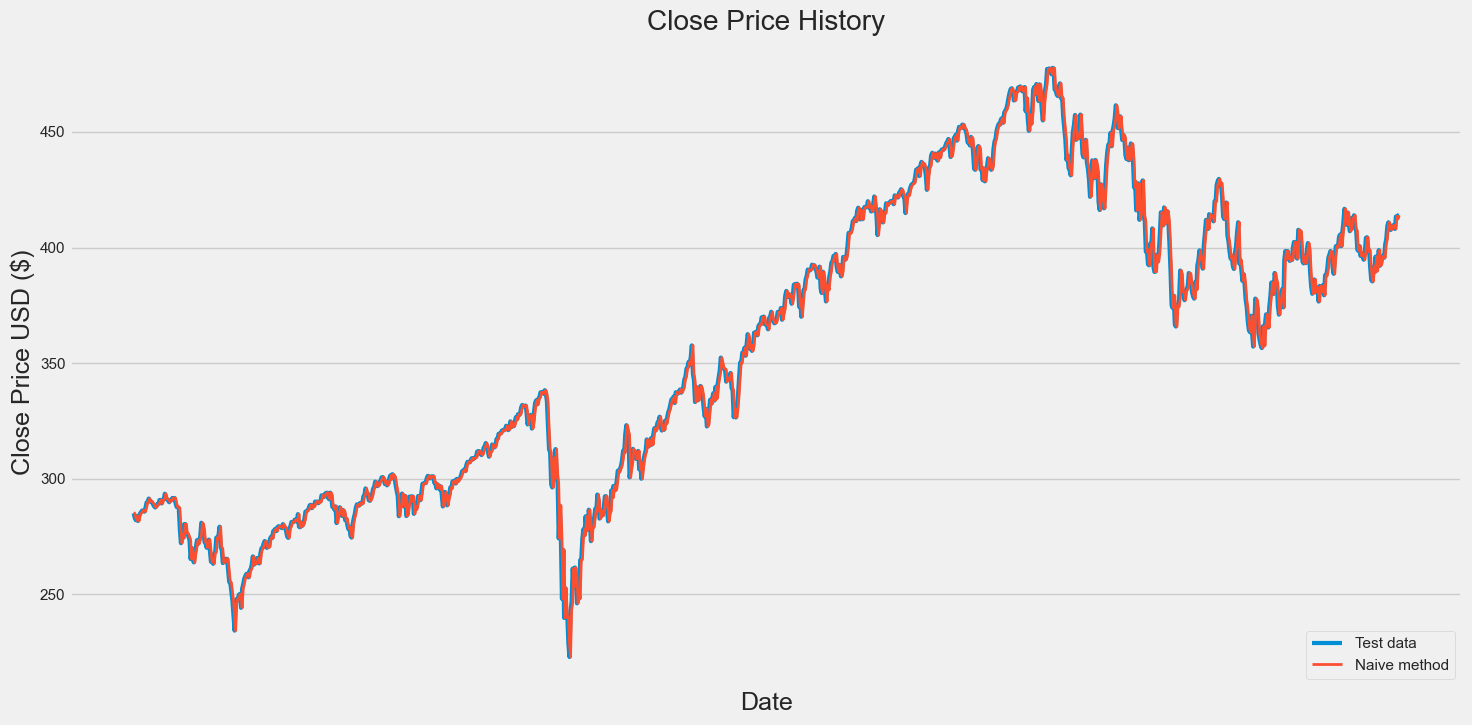

In [30]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.plot(naive_pred, linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(['Test data', 'Naive method'],loc='lower right')
plt.xticks([])
plt.show()

# SECTION 6 - #2 Moving Average

In [40]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values

test_data_len=len(dataset)-math.ceil(len(dataset)*.8)
print("testing data size:", test_data_len)
test_data = dataset[-test_data_len:, : ]

testing data size: 1180


In [41]:
def MA(dataset, test_length, window_size):
    MA_pred = []
    if len(dataset) < test_length + window_size + 1:
        return [np.mean(dataset[:i]) for i in range(1, len(dataset) + 1)]
    test_data = dataset[-test_length:, :]

    for i in range(test_length, 0, -1):
        MA_pred.append(np.mean(dataset[(-i - window_size):(-i)]))
    
    return MA_pred

In [42]:
grid = [5, 10, 50 ,100 ,200]

In [43]:
for windowsize in grid:
    print(f"RMSE of window size {windowsize}\t:", calculate_rmse(test_data, MA(dataset, test_data_len, windowsize)))

RMSE of window size 5	: 6.472304591782865
RMSE of window size 10	: 8.397305149847842
RMSE of window size 50	: 16.63162171227357
RMSE of window size 100	: 21.423585974507596
RMSE of window size 200	: 30.66496767244235


**Plot of different MA window sizes**

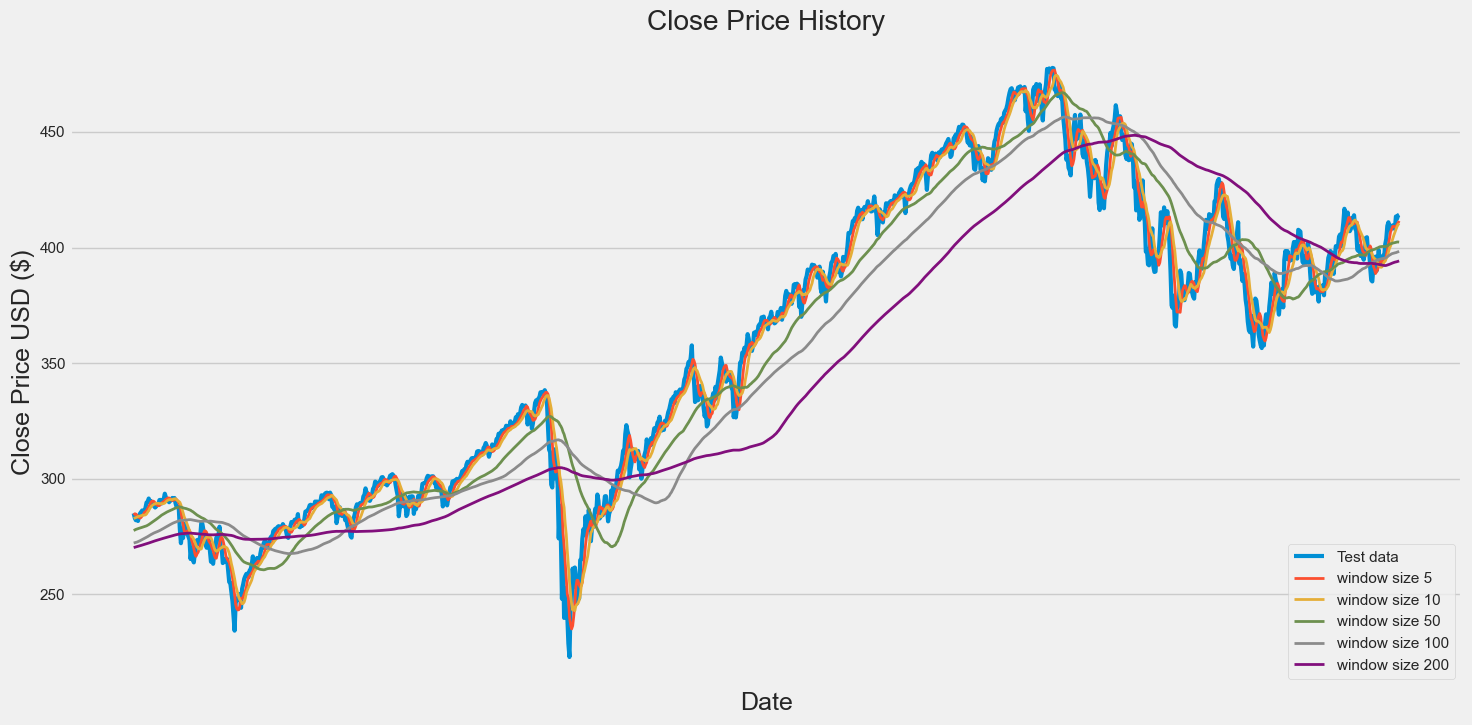

In [44]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
legend = ['Test data']

for windowsize in grid:
    plt.plot(MA(dataset,test_data_len, windowsize), linewidth=2)
    legend.append(f"window size {windowsize}")
plt.legend(legend,loc='lower right')
plt.xticks([])
plt.show()

# SECTION 7 - #3 EXPONENTIAL SMOOTHING

**Exponential smoothing without trend**

In [8]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values
train_data_len = math.ceil(len(dataset)*.8)
test_data_len=len(dataset) - train_data_len
print("testing data size:", test_data_len)
train_data = dataset[:train_data_len, :]
test_data = dataset[-test_data_len:, : ]

testing data size: 1180


In [9]:
alpha_grid = np.linspace(0,1,1001)

In [124]:
minimal = 100
saved_alpha = 0
for alpha in alpha_grid:
    ES_pred = [float(train_data[0])]

    for i in range(1, train_data_len):
        ES_pred.append(float(alpha * train_data[i-1] + (1 - alpha) * ES_pred[i-1]))
    
    if minimal > calculate_rmse(train_data, ES_pred):
        minimal = calculate_rmse(train_data, ES_pred)
        saved_alpha = alpha
        saved_ES_pred = ES_pred
        
print("optimal alpha\t:", saved_alpha)
print("training RMSE\t:", minimal)

optimal alpha	: 0.9420000000000001
training RMSE	: 1.5460774333219414


In [125]:
alpha = saved_alpha

ES_test_pred = [float(test_data[0])]

for i in range(1, test_data_len):
    ES_test_pred.append(float(alpha * test_data[i-1] + (1 - alpha) * ES_test_pred[i-1]))
    
print("testing RMSE\t:", calculate_rmse(test_data, ES_test_pred))

testing RMSE	: 4.598907266468322


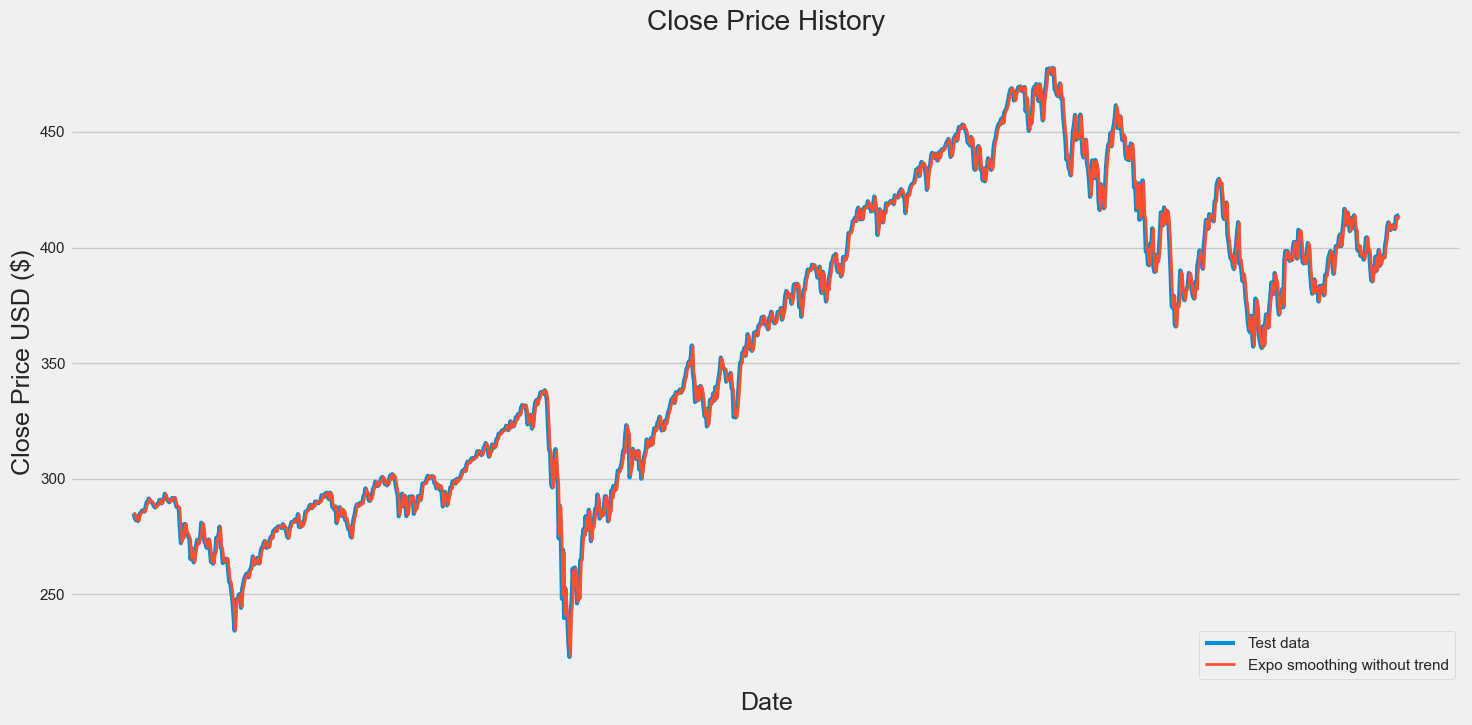

In [126]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.plot(ES_test_pred, linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(['Test data', 'Expo smoothing without trend'],loc='lower right')
plt.xticks([])
plt.show()

**Exponential smoothing with trend**

In [12]:
alpha_grid = np.linspace(0,1,1001)
beta_grid = np.linspace(0,1,101)

In [13]:
minimal = 100
saved_alpha = 0
saved_beta = 0

for alpha in alpha_grid:
    for beta in beta_grid:
        B = [float(train_data[0])]
        T = [float(train_data[1] - train_data[0])]
        ES_trend_pred = [float(train_data[0])]

        for i in range(1, train_data_len):
            B.append(float(alpha * train_data[i-1] + (1 - alpha) * ES_trend_pred[i-1]))
            T.append(float(beta * float(B[i] - B[i-1]) + (1 - beta) * float(T[i-1])))
            ES_trend_pred.append(float(B[i] + T[i]))
        
        if minimal > calculate_rmse(train_data, ES_trend_pred):
            minimal = calculate_rmse(train_data, ES_trend_pred)
            saved_alpha = alpha
            saved_beta = beta
            saved_ES_trend_pred = ES_trend_pred
            
print("Optimal alpha\t:", saved_alpha)
print("Optimal beta\t:", saved_beta)
print("training RMSE\t:", minimal)

Optimal alpha	: 0.9430000000000001
Optimal beta	: 0.01
training RMSE	: 1.5540022338583932


In [36]:
alpha = saved_alpha
beta = saved_beta

B = [float(test_data[0])]
T = [float(test_data[1] - test_data[0])]
ES_trend_test_pred = [float(test_data[0])]

for i in range(1, test_data_len):
    B.append(float(alpha * test_data[i-1] + (1 - alpha) * ES_trend_test_pred[i-1]))
    T.append(float(beta * float(B[i] - B[i-1]) + (1 - beta) * float(T[i-1])))
    ES_trend_test_pred.append(float(B[i] + T[i]))

print("testing RMSE\t:", calculate_rmse(test_data, ES_trend_test_pred))

testing RMSE	: 4.630746278848413


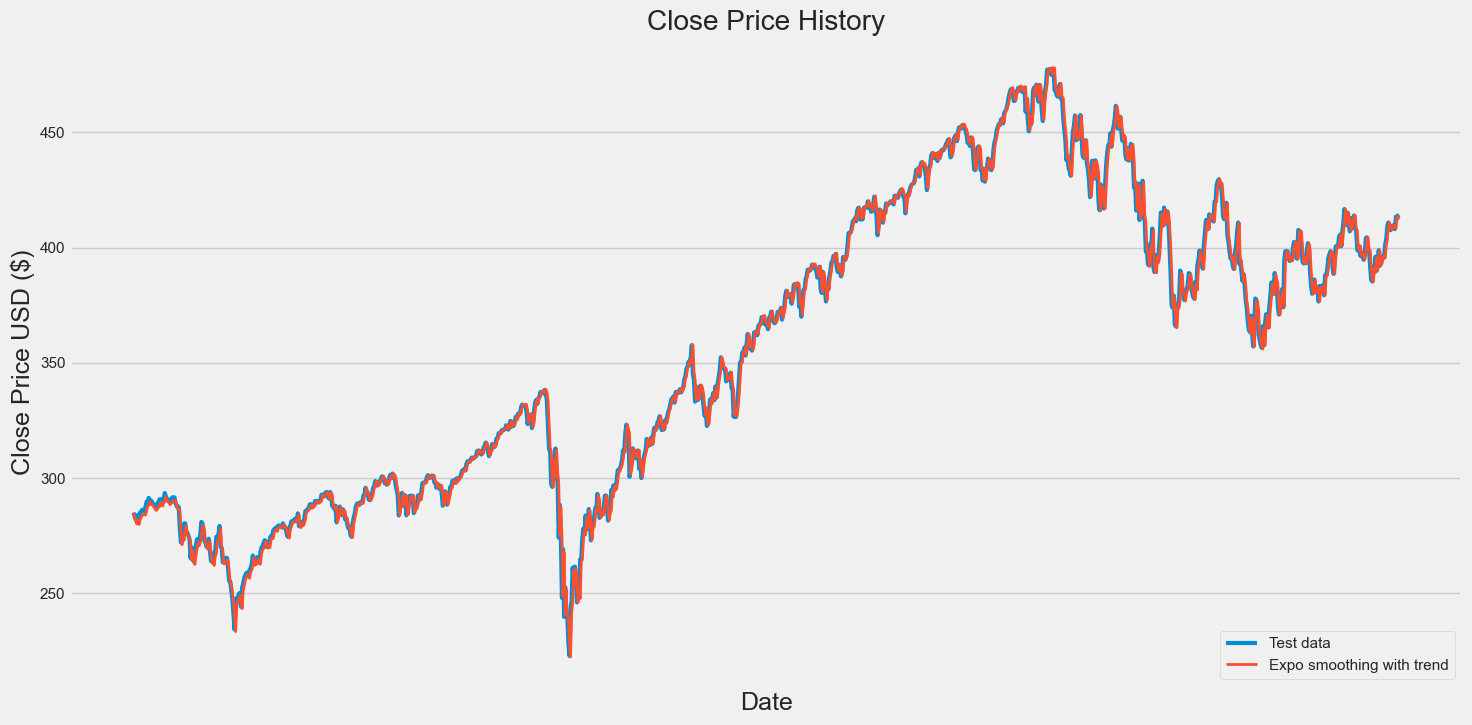

In [37]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data, linewidth=3)
plt.plot(ES_trend_test_pred, linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(['Test data', 'Expo smoothing with trend'],loc='lower right')
plt.xticks([])
plt.show()

# SECTION 8 - #4 LSTM

In [45]:
data = pd.DataFrame(stock_cleaned_data)

In [46]:
data.drop(['volume'], axis=1, inplace = True)
data['MA100'] = MA(dataset, len(dataset), 100)
data['MA100'].shift(-1)

import pandas_ta as ta
data['RSI']=ta.rsi(data['adjclose'], length=15)
data['target'] = data['adjclose'].shift(-1)
data.dropna(inplace = True)
data.head()

,open,high,low,close,adjclose,MA100,RSI,target
date,,,,,,,,
1999-11-22,142.437500,143.000000,141.5000,142.468704,92.711392,138.830063,79.387602,91.897955
1999-11-23,142.843704,142.843704,140.3750,141.218704,91.897955,138.970571,71.264847,92.386017
1999-11-24,140.750000,142.437500,140.0000,141.968704,92.386017,139.137134,73.038272,92.040336
1999-11-26,142.468704,142.875000,141.2500,141.437500,92.040336,139.258206,69.770625,91.714962
1999-11-29,140.875000,141.921799,140.4375,140.937500,91.714962,139.342171,66.758564,90.637129


In [53]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data)
scale = np.max(data['target']) - np.min(data['target'])
print(data_set_scaled)

[[0.18111582 0.17805747 0.18192489 ... 0.31620353 0.8936042  0.09647095]
 [0.1821035  0.17767624 0.17917401 ... 0.31809466 0.77558104 0.09764265]
 [0.17701267 0.17668545 0.17825705 ... 0.32033647 0.80134881 0.09681277]
 ...
 [0.82969825 0.83867506 0.83355878 ... 0.99898    0.66414476 0.86605357]
 [0.83852457 0.84172399 0.83861502 ... 0.9994884  0.64145845 0.86960665]
 [0.83745471 0.83896775 0.84112138 ... 1.         0.66193279 0.87025484]]


In [49]:
X = []

backcandles = 60
print(data_set_scaled.shape[0])
for j in range(7):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

5887


In [50]:
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X.shape)
print(y.shape)

(5827, 60, 7)
(5827, 1)


In [51]:
train_data_len = int(len(X)*0.8)
print(train_data_len)
X_train, X_test = X[:train_data_len], X[train_data_len:]
y_train, y_test = y[:train_data_len], y[train_data_len:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

4661
(4661, 60, 7)
(1166, 60, 7)
(4661, 1)
(1166, 1)


In [59]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 7), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=60, shuffle=True, validation_split = 0.1)

Epoch 1/60
280/280 [==============================] - 10s 26ms/step - loss: 3.5698e-04 - val_loss: 1.3062e-04
Epoch 2/60
280/280 [==============================] - 7s 25ms/step - loss: 5.0355e-05 - val_loss: 4.4717e-05
Epoch 3/60
280/280 [==============================] - 6s 23ms/step - loss: 4.0852e-05 - val_loss: 4.6437e-05
Epoch 4/60
280/280 [==============================] - 8s 28ms/step - loss: 2.9647e-05 - val_loss: 3.1627e-05
Epoch 5/60
280/280 [==============================] - 7s 24ms/step - loss: 3.7474e-05 - val_loss: 4.0557e-05
Epoch 6/60
280/280 [==============================] - 7s 24ms/step - loss: 2.9322e-05 - val_loss: 3.1326e-05
Epoch 7/60
280/280 [==============================] - 7s 24ms/step - loss: 2.5744e-05 - val_loss: 3.3296e-05
Epoch 8/60
280/280 [==============================] - 7s 24ms/step - loss: 2.6670e-05 - val_loss: 7.4700e-05
Epoch 9/60
280/280 [==============================] - 7s 24ms/step - loss: 2.4489e-05 - val_loss: 1.6685e-04
Epoch 10/60
280/28

In [60]:
y_train_pred = model.predict(X_train)
print("training RMSE:", calculate_rmse(y_train_pred, y_train) * scale)

146/146 [==============================] - 3s 16ms/step
training RMSE: 1.677478115466438


**Testing the accuracy of the LSTM Model**

In [61]:
y_test_pred = model.predict(X_test)
print("testing RMSE:", calculate_rmse(y_test_pred, y_test) * scale)

37/37 [==============================] - 1s 20ms/step
testing RMSE: 6.366580855789453


<function matplotlib.pyplot.show(close=None, block=None)>

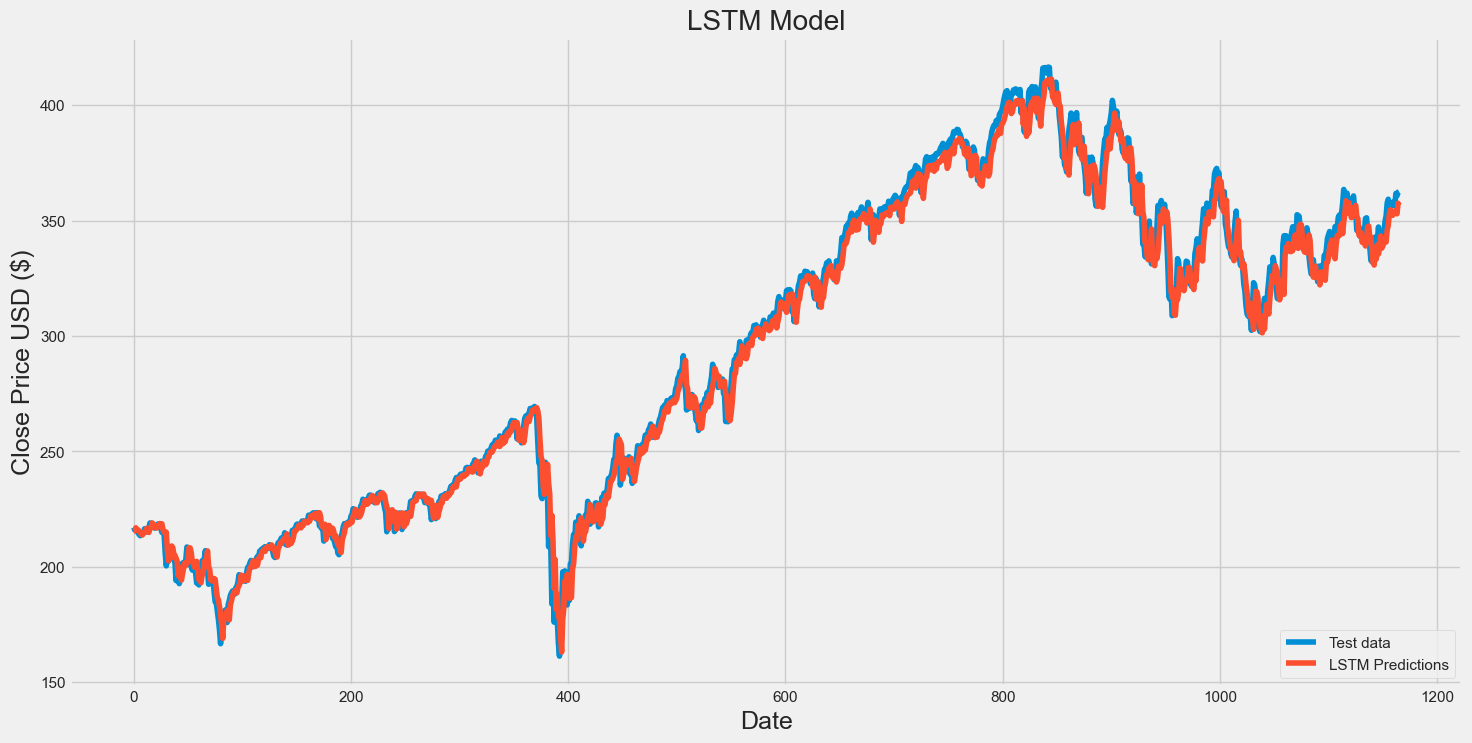

In [63]:
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(y_test * scale)
plt.plot(y_test_pred * scale)
plt.legend(['Test data','LSTM Predictions'],loc='lower right')
plt.show

# Conclusion

To summarize, below are the RMSE values obatained by our models:
* 